In [1]:
import gc,sys
import pdb

#pdb.set_trace()
from tqdm import tqdm

import os, mlflow, mlflow.pytorch
import __init__

from transformation.gp_cpab import gp_cpab
from transformation.configManager import configManager
from extra.utilities import *
from extra.dataLoaderDiffeo import *
from extra.LossFunctionsAlternatives import LossFunctionsAlternatives
from extra.Automatic_Report import Generate_Automatic_Report
from transformation.libcpab.libcpab.pytorch.interpolation import interpolate1D

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [2]:
import argparse; import sys; sys.argv=['']; del sys

def argparser():
    """ Argument parser for the main script """
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    # CPAB Setup for Gaussian Process Interpolation
    gpsetup = parser.add_argument_group('GPSetup')
    gpsetup.add_argument('--Task', type=int, default = 5, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=float, default = 0.25, help='multitaks-gp initialization')
    gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.0, 0.33, 0.33, 0.33], help='multitaks-gp initialization') #[0.0, 0.33, 0.33, 0.33] #[0.5, 0.5]
    gpsetup.add_argument('--Lengthscale', type=float, default = 0.25, help='lengthscale on square-exponential kernel') # *** 0.5 *** #0.25, #0.5 + init gives better for 2 gaps case, # 1.25
    gpsetup.add_argument('--noise_constraint', type=list, default = [0,0.0004], help='noise constrain') #16
    gpsetup.add_argument('--Option', type=str, default = 'multitask', help='noise constrain') #16

    # Paths to use
    paths = parser.add_argument_group('Paths')
    paths.add_argument('--path_orig', type=str, default="../../data/orig_3aa.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta
    paths.add_argument('--path_target', type=str, default="../../data/ref_3aa.aln", help='Reference sequence as my desired output') #ref_3aa3g.aln
    paths.add_argument('--path_preexist_linear', type=str, default="../../models/CPABlinear3.pth", help='prebuilt model using linear case') 
    paths.add_argument('--path_preexist_gp', type=str, default="../../models/CPABGPB3.pth", help='prebuilt model using gp case')
    paths.add_argument('--path_automated_report', type=str, default="../../Results", help='path to save automatic report') 
    paths.add_argument('--logdir', type=str, default="../../Results", help='where to store results')
    
    # CPAB features
    cpab = parser.add_argument_group('CPAB')
    cpab.add_argument('--device', type=str, default="cpu", help='device')
    cpab.add_argument('--modeflag', type=str, default="1D", help='dimensionality of tesselation')
    cpab.add_argument('--window_grid', type=int, default=4, help='number of tesselation cells') #6
    cpab.add_argument('--channels', type=int, default=4, help='amount of channels for estimation --deprecated')
    cpab.add_argument('--interpolation_type', type=str, default="GP", help='type of interpolation between maps') 

    # Optimization
    opt = parser.add_argument_group('Optimization')
    opt.add_argument('--lr', type=float, default=0.001, help='learning rate') #0.01, # 0.00001 just for testing the behavior for non init thetas
    opt.add_argument('--weight_decay', type=float, default=0.0004, help='L2 regularization')
    opt.add_argument('--maxiter', type=int, default=500, help='max number of epochs') #500 iters or less
    opt.add_argument('--lossfunctmetric', type=str, default='Soft_Label_KLD', help='initial loss function') # 'JSD','Soft_Label_KLD', 'SKL'

    # LogosPlot
    logos = parser.add_argument_group('logos')
    logos.add_argument('--scale_factor', type=int, default=10, help='scale factor')
    logos.add_argument('--mode', type=str, default='see_train', help='mode') 

    # Parse and return
    args = parser.parse_args()
    return args

In [3]:
print(__package__)
args = argparser()
'''---------------------------------------------------------'''
std = configManager(args)



device = std.parserinfo('device')
modeflag = std.parserinfo('modeflag')
window_grid = std.parserinfo('window_grid')
channels = std.parserinfo('channels')
option = std.parserinfo('Option')
lossmetric = std.parserinfo('lossfunctmetric')

path = std.parserinfo('path_orig')
path_MSA_test = std.parserinfo('path_target')#PathMSAref4t
path_preexist_model = std.parserinfo('path_preexist_linear')
path_preexist_modelGP = std.parserinfo('path_preexist_gp')

pathX123 = std.parserinfo('path_automated_report')
indexlogolinear = '_LI_3aa9g_padd'
indexlogoGP = '_GP_3aa9g_padd'
indexoutputT = 'debugging_cpab_domains.txt' #'results_3aa_Inverse_direct.txt'
#self.config, self.constrain, self.tasks, self.interpolation_type, self.option 
gp_params = std.get_config_vals(['noise_constraint','Task','interpolation_type','Option','Lengthscale','Initialization'])
print('Ok')
padding_criteria = 'padding_weights'  # 'padding_weights', 'none'


None
Ok


In [4]:
def padding_pattern_input_target(x1, ref_msa, token, alphabet_dict):

    padd_replication = abs(ref_msa.shape[1] - x1.shape[1])
    padd = torch.tensor([])

    if padd_replication!=0:
        if token == 'gap':
            channel_factor = 1./ref_msa.shape[2]
            padd = torch.ones(1,padd_replication,ref_msa.shape[2])*channel_factor
        elif token == 'token':
            if '-' in alphabet_dict: token_number, num_class = alphabet_dict['-'], len(alphabet_dict)
            # in case there not exist the token, we have to append it as column to 
            # the target, because we are including the new symbol in the dictionary
            else: token_number, num_class = len(alphabet_dict),len(alphabet_dict)+1; ref_msa = torch.cat( (ref_msa,torch.zeros(ref_msa.shape[0],ref_msa.shape[1],1)), 2 )

            padd = F.one_hot(torch.tensor(token_number), num_class).repeat(1,padd_replication,1)#.repeat(1,padd_replication,len(alphabet_dict))
        
        # conditional where input is filled with padding to
        # equal target length or backwards depending of their difference
        if x1.shape[1] <= ref_msa.shape[1]: x1 = torch.cat(( x1 ,padd),1)
        else: ref_msa = torch.cat(( ref_msa ,padd),1)
        

    outsize = (ref_msa.shape[1], ref_msa.shape[2])
    padded_idx = [*range(x1.shape[1],ref_msa.shape[1])]
    non_padded_idx = set(range(0, outsize[0])) - set(padded_idx) 
    non_padded_idx = [*non_padded_idx]

    ''' TEMP SOLUTION FOR THE EXPERIMENT WITH THE MODIFICATIONS'''
    '''---------------------------------------------------------------------------'''
    padded_idx = non_padded_idx[(ref_msa.shape[1] - padd_replication):]; non_padded_idx =  non_padded_idx[:(ref_msa.shape[1] - padd_replication)]
    '''---------------------------------------------------------------------------'''

    padded_idx = [ padded_idx ]; non_padded_idx = [ non_padded_idx ]
    return padded_idx, non_padded_idx, x1, ref_msa, outsize

## Option 2 Padding_pattern_input_target

In [5]:
def fill_seqs_with_symbols(seq, padd_replication, c2i, symbol='gap'):
    if symbol == 'gap':
        channel_factor = 1./(seq.shape[2]-1) #1./seq.shape[2]
        padd = torch.ones(1,padd_replication,seq.shape[2]) * channel_factor
        padd[:,:,0]=0
    elif symbol == 'token':
        classes = len(c2i.keys())
        token = F.one_hot(torch.tensor(c2i['-']), classes)
        padd = token.repeat(1,padd_replication,1)
    elif symbol == 'token_target':
        classes = len(c2i.keys())
        token = F.one_hot(torch.tensor(c2i['.']), classes)
        padd = token.repeat(1,padd_replication,1)

    return torch.cat(( seq ,padd),1)

def replace_target_token_gaps(seq, c2i, token_sym):
    token_val = c2i[token_sym]
    val_gap = torch.ones(seq.shape[2])*1./(seq.shape[2]-1)
    val_gap[0]=0.0
    seq[seq.argmax(-1)==token_val] =  val_gap
    return seq

def padding_strategy_input_target(x1, ref_msa, token_x, token_target, c2i, after_bound = 4):

    len_inp = x1.shape[1]
    len_target = ref_msa.shape[1]
    padd_replication = ref_msa.shape[1] - x1.shape[1]

    # make input and target to same size
    if padd_replication > 0:
        x1 = fill_seqs_with_symbols(x1, abs(padd_replication), c2i, symbol=token_x)
        outsize = len_target + after_bound
    elif padd_replication < 0:
        ref_msa = fill_seqs_with_symbols(ref_msa, abs(padd_replication), c2i, symbol=token_target)
        outsize = len_inp + after_bound
    else: outsize = len_target

    # increase input and target seq size after the matching of both bound sizes
    if '-' in c2i: 
        x1 = fill_seqs_with_symbols(x1, after_bound, c2i, symbol=token_x)
        if token_target != 'token_target':
            ref_msa = replace_target_token_gaps(ref_msa, c2i, '.')
        ref_msa = fill_seqs_with_symbols(ref_msa, after_bound, c2i, symbol=token_target)    

    return x1, ref_msa, (outsize,outsize)


# Reference Information - how the alignment should looks like
alph = ['-','.', 'L', 'Q', 'R']
alignment, ref_msa, alphabets, c2i, i2c, i2i,seqchar = read_clustal_align_output(path_MSA_test, alphabet=alph)
# Raw Sequences, to see if we can align the sequences somehow
dataset_msa = datasetLoader(pathBLAT_data = path, alphabet = alphabets, enable_variable_length=True)

x1 = dataset_msa.prot_space
fill_inp = 'token'
fill_target = 'token_target' #'gap'

x1, ref_msa, outsize = padding_strategy_input_target(x1.float(), ref_msa.float(), fill_inp, fill_target, c2i, after_bound = 5)
print('final input: \n {0} \n'.format(x1))
print('final target: \n {0} \n'.format(ref_msa))



tmp
final input: 
 tensor([[[0., 0., 0., 1., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.]]]) 

final target: 
 tensor([[[0., 0., 0., 1., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 1.],
         [0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0.]]]) 



In [6]:
import pandas as pd
from extra.logomakers import logomaker_plots 

#def plot_logos_probs(x1_trans, alphabets, folderpath = pathfolder, name = path):  
def plot_logos_probs(x1_trans, alphabets, **kargs): #folderpath = pathfolder, name = path):  
    #from logomakers import logomaker_plots  


    alphabets_logo = [ i if i!='-' else 'X' for i in alphabets] 
    x1_trans_logo_input = df_construction_aas([ x1_trans.detach().numpy() ]*500, x1_trans.shape, alphabets_logo)
    best = logomaker_plots.plotlogos(x1_trans_logo_input[x1_trans_logo_input.columns.tolist()] )

    return best

In [7]:
print(__package__)
from tensorboardX import SummaryWriter
import time, os, datetime
# Logdir for results
if args.logdir == '':
    logdir = args.logdir + '/res/' + 'gp_cpab_tests' + '/' + datetime.datetime.now().strftime('%Y_%m_%d_%H_%M')
else:
    logdir = args.logdir + '/res/' + 'gp_cpab_tests'
  
writer = SummaryWriter(log_dir=logdir)

def training_theta_optima(path_preexist_model, theta_est, maxiter, optimizer, T,x1, ref_msa, modeflag, msa_num, loss_vals, loss_function, inverse):

 
    if os.path.isfile(path_preexist_model):
        print ("Loading Deformation Model")
        theta_est = torch.load(path_preexist_model)
    else:
        pb = tqdm(desc='Alignment of samples', unit='iters', total=maxiter)
        for i in range(maxiter):
            optimizer.zero_grad()

            if inverse == True:
                opt_est = -theta_est

                x1_trans, sampled_data, forw_per = T.spatial_transformation(x1, ref_msa, opt_est, modeflag)
                loss = loss_function(method = lossmetric, input = x1_trans, target = ref_msa, forw_per=forw_per) # 'JSD','Soft_Label_KLD'


            loss_vals.append(loss.item())
            loss.backward()
            optimizer.step()

            gc.collect()
            torch.cuda.empty_cache()
            #torch.save(theta_est, path_preexist_model)

            pb.update()
            pb.set_postfix({'loss': str(loss.item())})

            msa_num.append(x1_trans.detach().numpy().squeeze())


        pb.close()
        shapes = ref_msa.squeeze().shape
        msa_num = np.vstack(msa_num).reshape(-1, shapes[0], shapes[1])


    return theta_est


#writer.add_scalar('test/total_loss', test_loss, iteration)
#writer.add_image('samples/samples', make_grid(samples.cpu(), nrow=n), 
#                                 global_step=epoch)

def get_interpolated_data(data, T, outsize):
    data1=data.unsqueeze(0)
    grid = T.uniform_meshgrid(outsize).repeat(data1.shape[0],1,1)
    out = interpolate1D(data1,grid,outsize)
    return out.squeeze(0)


None


In [8]:
def define_data_and_transformations(path_MSA_test, path, gp_params, option, T, type_of_fill='token,gap', length_filling = 3, **kargs):

    if 'alphabet' in kargs:
        dict_aas = kargs['alphabet']
    # Reference Information - how the alignment should looks like
    alignment, ref_msa, alphabets, c2i, i2c, i2i,seqchar = read_clustal_align_output(path_MSA_test, alphabet = dict_aas)
    # Raw Sequences, to see if we can align the sequences somehow
    dataset_msa = datasetLoader(pathBLAT_data = path, alphabet = alphabets, enable_variable_length=True)

    x1 = dataset_msa.prot_space
    #padded_idx, non_padded_idx, x1, ref_msa, outsize = padding_pattern_input_target(x1, ref_msa, type_of_fill, c2i)

    x1 = T.backend.to(x1.clone().detach(), device=device)
    ref_msa = T.backend.to(ref_msa.clone().detach(), device=device)

    fill_inp , fill_target = type_of_fill.split(',')
    x1, ref_msa, outsize = padding_strategy_input_target(x1.float(), ref_msa.float(), fill_inp, fill_target, c2i, after_bound = length_filling)
    padded_idx, non_padded_idx = [[]], [[]]

    ''' LIKELIHOOD DEFINITIONS:'''
    
    if option == 'multitask':

        T.get_interpolation_inductive_points(x1, x1.float(), 
                                            outsize = outsize, 
                                            padded_idx = padded_idx, 
                                            non_padded_idx = non_padded_idx,
                                            #separation_size_grid = T.params.inc[0],
                                            padding_option = padding_criteria  )
                                            #padding_option = 'none'   )
    
    return alphabets, c2i, i2c, i2i, dataset_msa, padded_idx, non_padded_idx, x1, ref_msa, outsize, T

        
    #return alphabets, c2i, i2c, i2i, dataset_msa, padded_idx, non_padded_idx, x1, ref_msa, outsize, T

In [9]:
def define_thetas(init=True):
    
    ''' FOR CASES 1,2,3,4 GAPS WITH INVERSE'''

    #theta_ref = torch.autograd.Variable(torch.tensor([[-0.3,0.0011522,0.0018782, 0.2456, -0.3125]], requires_grad=True), requires_grad=True)
    #theta_ref  = get_interpolated_data(theta_ref, T, (T.params.nC+1,T.params.nC+1))
    ''' FOR CASES 10 GAPS WITH INVERSE'''
    #theta_ref = torch.autograd.Variable(torch.tensor([[0.003,  -0.006, 0.003, 0.006,  -0.003]], requires_grad=True), requires_grad=True)
    if init==True:
        '''REFERENCE FOR TEMPORARY SOLUTION 3AA 1,2,3,4 GAPS TESS SIZE 4 CELLS'''
        #theta_ref = torch.tensor([[-0.31, -0.06, -0.004, -0.01, 0.9875, -0.23, -0.2]]) *(-1 )
        '''REFERENCE FOR TEMPORARY SOLUTION 3AA 1,2,3,4 GAPS TESS SIZE 4 CELLS'''
        #theta_ref = torch.autograd.Variable(torch.tensor([[-0.3,0.0011522,0.0018782, 0.2456, -0.3125]], requires_grad=True), requires_grad=True)
        '''REFERENCE FOR IDEAL CASE 3 AA 3 GAPS''' #***********
        theta_ref = torch.autograd.Variable(torch.tensor([[0.0011, 0.019, -0.119, -0.015356, 0.952]],requires_grad=True), requires_grad = True )*(-1)
        '''REFERENCE FOR IDEAL CASE 3 AA 1 GAP CASE ONE -> SEE ORIG3AAG VS REF_3AA token,token'''
        #theta_ref = torch.autograd.Variable(torch.tensor([[-0.3,0.0011522,0.00018782, 0.002456, -0.0125]], requires_grad=True), requires_grad=True)
        '''REFERENCE FOR IDEAL CASE 3 AA 1 GAP CASE ONE -> SEE ORIG3AA VS REF_3AA'''
        #theta_ref = torch.autograd.Variable(torch.tensor([[-0.3,0.0011522,0.0018782, 0.2456, -0.3125]], requires_grad=True), requires_grad=True)
        '''JUST FOR EXAMINING THE SUBOBTIMAL SOLUTION'''
        #theta_ref = torch.autograd.Variable( torch.tensor([[ 0.1934,  0.1863, -0.0259,  0.1988,  0.1951]], requires_grad=True) ,requires_grad = True) # A)
        #theta_ref = torch.autograd.Variable( torch.tensor([[ 0.2757,  0.3758, -0.2276,  0.3919,  0.3862]], requires_grad=True) ,requires_grad = True)  # B)
        #theta_ref = torch.autograd.Variable( torch.tensor([[ 0.0637,  0.5615, -0.4211,  0.5806,  0.5747]], requires_grad=True) ,requires_grad = True)  # C)
        #theta_ref = torch.autograd.Variable( torch.tensor([[-0.1374,  0.7423, -0.6146,  0.7648,  0.7556]], requires_grad=True) ,requires_grad = True)  # D)
        
        

    else:
        theta_ref = torch.autograd.Variable(T.identity(1, epsilon=1e-6), requires_grad=True)
    theta_est = torch.autograd.Variable(theta_ref.clone(), requires_grad=True)
    theta_est_GP = torch.autograd.Variable(theta_ref.clone(), requires_grad=True)
    return theta_ref, theta_est, theta_est_GP

def optimization_setup(conf, theta_est, theta_est_GP, c2i, i2c, i2i, keys = ['lr','weight_decay','maxiter']):
    '''lr=0.01 is the best one so far for linear interpolation and gp'''
        
    lr, wd, maxiter = conf.get_config_vals(keys)
    #lr = std.parserinfo('*/lr') 
    #wd = std.parserinfo('*/weight_decay')
    #maxiter = std.parserinfo('*/maxiter')

    optimizer = torch.optim.AdamW([theta_est], lr=lr) #, weight_decay=wd)
    optimizerGP = torch.optim.AdamW([theta_est_GP], lr=lr)


    loss_function = LossFunctionsAlternatives()
    loss_function.get_dictionaries_to_mask_data(c2i, i2c, i2i)

    return lr, wd, maxiter, optimizer, optimizerGP, loss_function


In [10]:

def plot_irregular_table(cm, x_lab, y_lab,cmap='viridis'): 
    import itertools 

    figure, ax = plt.subplots(figsize=(8,10)) # plt.figure(figsize=(15,15))
    if cmap=='none':
        im = ax.imshow(cm, interpolation='None') 
    else:
        im = ax.imshow(cm, interpolation='None', cmap='viridis') 
    ax.set_title("value matrix") 
    #ax.set_colorbar() 
    tick_marks_x = np.arange(0.5,len(x_lab)+0.5) 
    tick_marks_y = np.arange(0.5,len(y_lab)+0.5) 

    ax.set_xticks(tick_marks_x, x_lab, rotation=45) 
    ax.set_yticks(tick_marks_y, y_lab)
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):   
        #color = "white" if cm[i, j] > threshold else "black"
        color = "white"
        ax.text(j, i, cm[i, j],  ha="center", va="center", color="w")  
    
    ax.set_ylabel('True label') 
    ax.set_xlabel('Predicted label') 
    
    ax.grid()
    plt.close()
    plt.cla()
    plt.clf()
    return figure
    '''
    plt.tight_layout() 
    return figure
    '''

def heatmap_from_tensor(data, alphabet, title):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    figure, ax = plt.subplots(figsize=(8,10))
    #ax = plt.axes()
    px = pd.DataFrame(data, columns=alphabet)
    ff=sns.heatmap(px, linewidth=1, linecolor='w', annot=data, ax = ax)
    ax.set_title(title)
    plt.close()
    plt.cla()
    plt.clf()
    return figure
    #plt.show()

#rr=heatmap_from_tensor(invtrans.detach().numpy()[0],['-','L','Q','R'], 'tmp')
#ff=plot_confusion_matrix(invtrans.detach().numpy()[0],['-','L','Q','R'],[0,1,2,3,4,5])

In [11]:
def training_exec_experiment(path_preexist_modelGP, theta_est_GP, maxiter, optimizerGP, T, x1 \
                            ,ref_msa ,modeflag, msa_numGP, loss_valsgp, loss_function, \
                            inverse = True, interp_inv = 'GP', interp_dir = 'linear'):

    T.interpolation_type = interp_inv
    theta_est_GP = training_theta_optima(path_preexist_modelGP, theta_est_GP, maxiter, optimizerGP, T, x1, ref_msa, 
                                                modeflag, msa_numGP, loss_valsgp, loss_function, inverse = inverse)

    # Executing inverse transform from optimal theta and using GPs as interpolator
    x1_trans3, sampled_data3, forw_per = T.spatial_transformation(x1, ref_msa, -theta_est_GP, modeflag)

    # Executing direct transform from optimal theta and using linear as interpolator
    T.interpolation_type = interp_dir
    x1_trans3_dir, _, forw_per = T.spatial_transformation(x1_trans3, ref_msa, theta_est_GP, modeflag)

    print("reverse transformed CPAB using GP: \n\n {0}".format(x1_trans3))
    xtrans_rev_logos = plot_logos_probs(x1_trans3, alphabets)
    writer.add_text('inverse_trans1', str(x1_trans3.detach().numpy()))
    print("direct transformed CPAB using linear with theta_GP: \n\n {0}".format(x1_trans3_dir))
    xtrans_dir_logos = plot_logos_probs(x1_trans3_dir, alphabets)
    writer.add_text('direct_trans1',str( str(x1_trans3_dir.detach().numpy())))

    # Plot logos in tensorboard
    writer.add_figure('inverse_trans_Fig_LOGOS', xtrans_rev_logos.fig)
    writer.add_figure('direct_trans_Fig_LOGOS', xtrans_dir_logos.fig)

    # Plot components in grid, due to lack of support for writting tensors inside tensorboard
    from torchvision.utils import make_grid
    writer.add_figure('Optimal Inverse Transform - Forward (-,L,Q,R)', heatmap_from_tensor(x1_trans3[0].detach().numpy(), alphabets, 'Forward (-,L,Q,R)') )
    writer.add_figure('Optimal Direct Transform - Backward (-,L,Q,R)', heatmap_from_tensor(x1_trans3_dir[0].detach().numpy(), alphabets, 'Backward (-,L,Q,R)') )

    # Info about grid deformations:
    grid_no_expansion = T.make_grids_for_Regresion(batch_size = x1.shape[0])
    grid_t_no_expansion_rev = T.transform_grid(grid_no_expansion, -theta_est_GP)
    grid_t_no_expansion_dir = T.transform_grid(grid_no_expansion, theta_est_GP)

    forward = torch.stack([grid_no_expansion.flatten() ,grid_t_no_expansion_rev.flatten(), grid_t_no_expansion_rev.flatten()*(x1.shape[1]-1)]).T
    backward = torch.stack([grid_no_expansion.flatten() ,grid_t_no_expansion_dir.flatten(), grid_t_no_expansion_dir.flatten()*(x1.shape[1]-1)]).T

    writer.add_text('Inverse T Deformation RAW',str( str(grid_t_no_expansion_rev.detach().numpy())))
    writer.add_text('Direct T Deformation RAW',str( str(grid_t_no_expansion_dir.detach().numpy())))
    writer.add_text('Inverse T Deformation SCALED',str( str(grid_t_no_expansion_rev.detach().numpy()*(x1.shape[1]-1) )))
    writer.add_text('Direct T Deformation SCALED',str( str(grid_t_no_expansion_dir .detach().numpy()*(x1.shape[1]-1) )))

    y_labs = list(range(grid_no_expansion.shape[-1]))
    plot_forward = heatmap_from_tensor(forward.detach().numpy(), ['input','raw','scaled'], 'FORWARD SCHEME' )
    plot_backward = heatmap_from_tensor(backward.detach().numpy(), ['input','raw','scaled'], 'BACKWARD SCHEME' )
    writer.add_figure('FORWARD',  plot_forward ) 
    writer.add_figure('BACKWARD',  plot_backward ) 



    return x1_trans3,x1_trans3_dir, theta_est_GP


tmp


/workspaces/Explicit_Disentanglement_Proteins/src/gp_cpab/src/transformation/libcpab/libcpab/pytorch/functions.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=dtype, device=device)


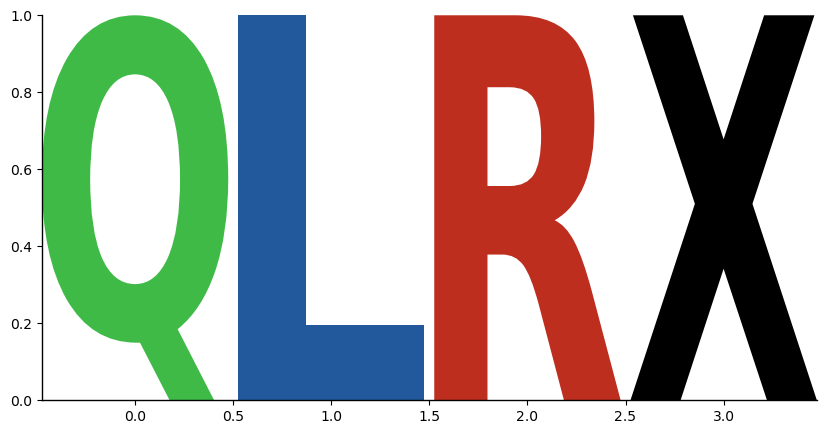

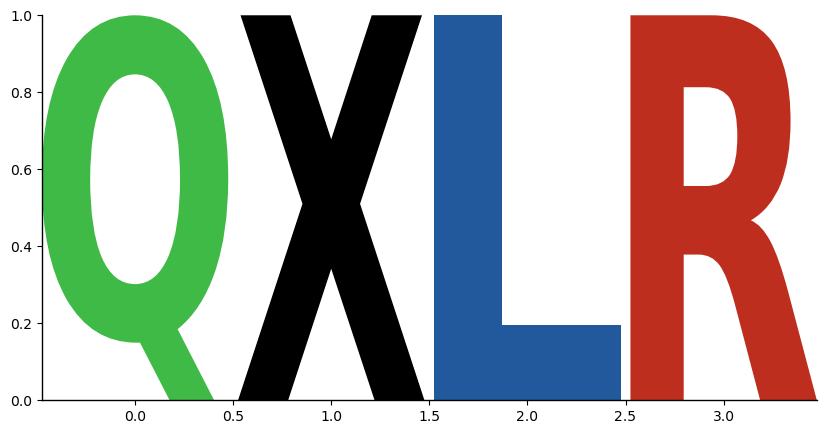

Alignment of samples: 100%|██████████| 500/500 [00:58<00:00,  8.54iters/s, loss=0.2274354249238968] 


reverse transformed CPAB using GP: 

 tensor([[[-2.2608e-20,  0.0000e+00,  5.9643e-04,  9.9879e-01,  5.9643e-04],
         [ 6.2602e-10,  0.0000e+00,  3.3032e-01,  3.3005e-01,  3.2964e-01],
         [-1.0628e-06,  0.0000e+00,  9.8909e-01,  5.3277e-03,  5.4253e-03],
         [-3.9096e-03,  0.0000e+00,  5.2228e-03,  5.1452e-03,  9.9339e-01]]],
       grad_fn=<PermuteBackward>)


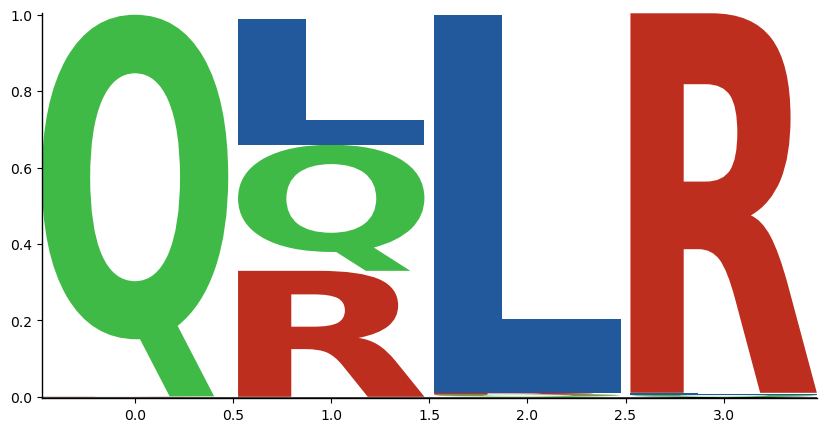

direct transformed CPAB using linear with theta_GP: 

 tensor([[[-2.4382e-09,  0.0000e+00,  5.8615e-04,  9.9799e-01,  1.3824e-03],
         [ 2.8189e-07,  0.0000e+00,  9.8305e-01,  6.7551e-03,  9.8859e-03],
         [-3.8417e-03,  0.0000e+00,  1.0528e-02,  1.0951e-02,  9.8203e-01],
         [-6.1709e-07,  0.0000e+00,  3.2995e-01,  3.2995e-01,  3.3010e-01]]],
       grad_fn=<PermuteBackward>)


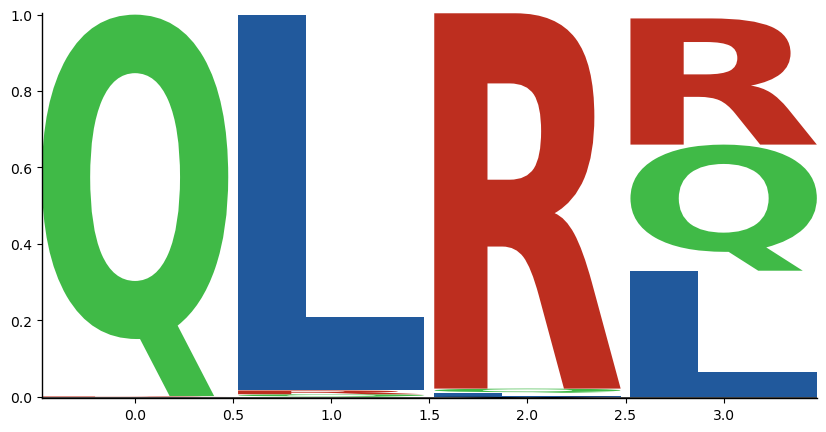

/opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c106IValue23reportToTensorTypeErrorEv
  warn(f"Failed to load image Python extension: {e}")


ModuleNotFoundError: No module named 'torch.ao'

In [12]:
'''Transformations for Reference Alignment'''
'''-----------------------------------------------------------------------------------------------'''
'''      JUST FOR CAPTURING DEFORMATION PATTERNS ALONG THE CPAB, HOW IT STARS AND IT ENDS:        '''
'''-----------------------------------------------------------------------------------------------'''
''' NEEDS TO BE IN ZERO_BOUNDARY IN FALSE FOR GETTING PROPER RESULTS IN ALIGNMENTS'''
from transformation.gp_cpab import gp_cpab
ndim = [window_grid]
T = gp_cpab(ndim, std, backend='pytorch', device=device, zero_boundary=False,
                                          volume_perservation=False, override=False, argparser_gpdata = gp_params)

fill_criteria = 'token,token_target' #'token,gap'
init_theta = True #True #True #False #True

alphabets, c2i, i2c, i2i, dataset_msa, \
padded_idx, non_padded_idx, x1, ref_msa,\
     outsize, T = define_data_and_transformations(path_MSA_test, path, gp_params, option, T, type_of_fill=fill_criteria, length_filling = 0, alphabet = ['-','.', 'L', 'Q', 'R']) #'token', 'gap'


theta_ref, theta_est, theta_est_GP = define_thetas(init=init_theta)

lr, wd, maxiter, optimizer, optimizerGP, loss_function = optimization_setup(std, theta_est, theta_est_GP, c2i, i2c, i2i, ['lr','weight_decay','maxiter'])

msa_num = []; loss_vals =[]
msa_numGP = []; loss_valsgp =[]

x1plot = plot_logos_probs(x1, alphabets)
refplot = plot_logos_probs(ref_msa, alphabets)

# Better with GP-GP configuration, instead of GP-Linear for inverse-reverse, why?
invtrans,dirtrans, theta_est_GP = training_exec_experiment(path_preexist_modelGP, theta_est_GP, maxiter, optimizerGP, T, x1 \
                            ,ref_msa ,modeflag, msa_numGP, loss_valsgp, loss_function, \
                            inverse = True, interp_inv = 'GP', interp_dir = 'GP') #linear

In [ ]:
print(theta_est_GP)

tensor([[-2.9850e-01,  1.1464e-03,  1.8688e-04,  2.4437e-03, -1.2438e-02]],
       requires_grad=True)


In [ ]:
import numpy as np

logdir_landscape = args.logdir + '/res/' + 'parameters_landscape'
  
writer_land = SummaryWriter(log_dir=logdir_landscape)

default_theta = torch.autograd.Variable(T.identity(1, epsilon=1e-6), requires_grad=True)
init_theta = torch.tensor([[0.0011, 0.019, -0.119, -0.015356, 0.952]],requires_grad=True)
Optimal_theta = torch.tensor([[-1.0655,  0.5902,  0.1982, -0.5455, -1.1456]], requires_grad=True)
SubOpt_theta_when_False = theta_est_GP#torch.tensor([[-0.6950,  1.8791, -0.9911,  2.5290, -0.5128]], requires_grad=True)

def landscape_analysis(init_theta, opt_theta, target_val, Wtboard, times=20):
    Ugrid = T.uniform_meshgrid(outsize).repeat(1,1,1)
    T_init_grid = T.transform_grid(Ugrid, -init_theta)
    T_opt_grid = T.transform_grid(Ugrid, -opt_theta)
    #times = 10 #500

    swept_grid = [ np.linspace( T_init_grid[:,:,i].detach().numpy(), T_opt_grid[:,:,i].detach().numpy(), times-1).flatten() for i in range(0,len(Ugrid.flatten())) ]
    swept_grid = np.array(swept_grid).T
    results = []; loss_evolution = []

    #cont=0
    for cont,i in enumerate(swept_grid):
        print(f'performing iteration {cont}: ')
        tmp_theta = np.interp(i, T_opt_grid.flatten().detach().numpy(), -opt_theta.flatten().detach().numpy()).reshape(1,-1)
        tmp_theta = torch.tensor( tmp_theta).float()
        x1_trans, sampled_data, forw_per = T.spatial_transformation(x1, ref_msa, tmp_theta, modeflag)
        loss = loss_function(method = lossmetric, input = x1_trans, target = target_val, forw_per=forw_per)
        results.append( (tmp_theta, T.transform_grid(Ugrid, tmp_theta), loss) )
        loss_evolution.append(loss.item())

    import matplotlib.pyplot as plt
    plt.plot(list(range(0,times-1)),loss_evolution)

    for res in results:
        #print("for position {0}, this is the information: \n\n".format(i) )
        print("theta:  {0}".format(res[0]))
        print("grid values after theta:  {0}".format(res[1]))
        print("loss value:  {0} \n\n".format(res[2]))


landscape_analysis(theta_est_GP, Optimal_theta, ref_msa, writer_land, 55)
#landscape_analysis(init_theta, Optimal_theta, ref_msa, writer_land, 55)



performing iteration 0: 


ValueError: fp and xp are not of the same length.